# Supervised Classification with SVM and Hyperparameter Tuning

This notebook implements the model training and evaluation steps outlined in the `README.md` file. It will load both original and cleaned datasets for Subsets A, B, and C, perform feature normalization, train SVM classifiers with an RBF kernel using RandomizedSearchCV for hyperparameter tuning, and evaluate their performance using F1-score, accuracy, and confusion matrices. Finally, it will compare the models trained on original vs. cleaned data using statistical tests and visualizations.

### Step 1: setup and imports

first, let's bring in all the tools we'll need. we're importing `pandas` for data handling, `numpy` for numerical operations, various `sklearn` modules for preprocessing, model selection, and metrics, `scipy.stats` for our statistical tests, and `matplotlib` and `seaborn` for plotting. we'll also set up some display options for `pandas` to make sure we can see all our data comfortably in the notebook.

In [20]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from scipy.stats import randint, uniform, wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# for consistent results
np.random.seed(42)

### Step 2: load datasets

next, we need to load all six datasets. we're defining a base directory for all your data files, then creating a list of dictionaries. each dictionary holds the path to a csv file and a descriptive name. this structured approach helps us keep track of which dataset we're working with as we loop through them for training and evaluation.

In [21]:
base_data_path1 = 'Subset_A/1_Original_Data'
base_cleaned_data_path1 = 'Subset_A/2_Clean_Data'

base_data_path2 = 'Subset_B/1_Original_Data'
base_cleaned_data_path2 = 'Subset_B/2_Clean_Data'

base_data_path3 = 'Subset_C/1_Original_Data'
base_cleaned_data_path3 = 'Subset_C/2_Clean_Data'

datasets = [
    {'name': 'subset_a_original', 'path': os.path.join(base_data_path1, 'original_data_for_classification.csv')},
    {'name': 'subset_a_cleaned', 'path': os.path.join(base_cleaned_data_path1, 'cleaned_data_for_classification.csv')},
    {'name': 'subset_b_original', 'path': os.path.join(base_data_path2, 'original_data_for_classification.csv')},
    {'name': 'subset_b_cleaned', 'path': os.path.join(base_cleaned_data_path2, 'cleaned_data_for_classification.csv')},
    {'name': 'subset_c_original', 'path': os.path.join(base_data_path3, 'original_data_for_classification.csv')},
    {'name': 'subset_c_cleaned', 'path': os.path.join(base_cleaned_data_path3, 'cleaned_data_for_classification.csv')},
]

loaded_data = {}
for ds_info in datasets:
    try:
        df = pd.read_csv(ds_info['path'], index_col=0)
        loaded_data[ds_info['name']] = df
        print(f"successfully loaded {ds_info['name']}: {df.shape}")
        
        # new code to display unique labels and their counts
        print(f"  --- unique labels in {ds_info['name']} (Specie ID) ---")
        if 'Specie ID' in df.columns:
            print(df['Specie ID'].value_counts().sort_values(ascending=True))
        elif 'specie id' in df.columns:
            print(df['specie id'].value_counts().sort_values(ascending=True))
        else:
            print("  'Specie ID' or 'specie id' column not found in this dataset.")
        print("-" * 50) # separator for readability

    except FileNotFoundError:
        print(f"error: {ds_info['name']} not found at {ds_info['path']}. please make sure the file exists.")
    except Exception as e:
        print(f"error loading {ds_info['name']}: {e}")

successfully loaded subset_a_original: (1465, 33)
  --- unique labels in subset_a_original (Specie ID) ---
Specie ID
Pitangus_sulphuratus             7
Ortalis_ruficauda                7
Alouatta_sp                      9
Dendroplex_picus                10
Amazona_amazonica               11
Crypturellus_soui               32
Crotophaga_ani                  33
Patagioenas_cayennensis         35
Troglodytes_aedon               36
Leptodactylus_fragilis          61
Dendropsophus_microcephalus    144
Nyctidromus_albicollis         152
Boana_platanera                264
Leptodactylus_fuscus           664
Name: count, dtype: int64
--------------------------------------------------
successfully loaded subset_a_cleaned: (1293, 33)
  --- unique labels in subset_a_cleaned (Specie ID) ---
Specie ID
Ortalis_ruficauda                3
Dendroplex_picus                 5
Alouatta_sp                      7
Amazona_amazonica                8
Crotophaga_ani                  11
Crypturellus_soui         

I dropped all classes with 3 or less entries for every dataset. In the end this meant dropping 2 for subset A and 1 for subset B

In [ ]:
species_to_drop = ['Pitangus_sulphuratus', 'Ortalis_ruficauda'] #for a orig

ao = loaded_data['subset_a_original']
aon = ao[~ao['Specie ID'].isin(species_to_drop)]
loaded_data['subset_a_original'] = aon

species_to_drop = ['Ortalis_ruficauda'] #for a clean
ac = loaded_data['subset_a_cleaned']
acn = ac[~ac['Specie ID'].isin(species_to_drop)]
loaded_data['subset_a_cleaned'] = acn

#'Leptopogon superciliaris'
species_to_drop = ['Sing bird 1'] #for b orig
bo = loaded_data['subset_b_original']
bon = bo[~bo['Specie ID'].isin(species_to_drop)]
loaded_data['subset_b_original'] = bon

species_to_drop = ['Sing bird 1'] #for b cleaned
bc = loaded_data['subset_b_cleaned']
bcn = bc[~bc['Specie ID'].isin(species_to_drop)]
loaded_data['subset_b_cleaned'] = bcn

### Step 3: preprocessing function

before we can train our models, we need to prepare the data. this function handles a few key steps: it separates the features (x) from the target labels (y), drops unnecessary columns like 'file', and then scales the features using `standardscaler`. feature scaling is super important here because it normalizes the range of features in the dataset, preventing features with larger values from dominating the learning process, which is crucial for algorithms like `svm`.

In [23]:
def preprocess_data(df):
    # assume 'specie id' is the target variable
    if 'specie id' in df.columns:
        x = df.drop(columns=['specie id', 'file'])
        y = df['specie id']
    elif 'Specie ID' in df.columns:
        x = df.drop(columns=['Specie ID', 'File'])
        y = df['Specie ID']
    else:
        raise ValueError("target column 'specie id' or 'specie ID' not found in dataframe")

    # normalize features
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)

    # encode target labels to numerical values
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    return x_scaled, y_encoded, label_encoder # return encoded y and the encoder

### Step 4: train and evaluate model function

this is the core of our training process. this function takes our preprocessed data and the dataset's name, then sets up an `svm` classifier. we're using `randomizedsearchcv` to efficiently find the best hyperparameters (c and gamma) for our `svm` with an `rbf` kernel. `stratifiedkfold` ensures that our 5 cross-validation folds maintain the same class distribution as the original dataset, which is important for balanced evaluation. after training, it evaluates the model's performance using f1-score and accuracy, and generates a confusion matrix. these metrics help us understand how well our model is classifying and where it might be making mistakes.

In [24]:
def train_and_evaluate_svm(x, y_encoded, dataset_name, label_encoder):
    print(f"\n--- training model for {dataset_name} ---")
    
    # define parameter distribution for randomizedsearchcv
    param_dist = {
        'C': uniform(loc=0.1, scale=100),
        'gamma': uniform(loc=0.001, scale=1),
        'kernel': ['rbf']
    }
    
    # use stratifiedkfold for cross-validation to ensure balanced folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # setup randomizedsearchcv
    random_search = RandomizedSearchCV(
        SVC(random_state=42),
        param_distributions=param_dist,
        n_iter=50,  # number of parameter settings that are sampled
        cv=cv,
        scoring='f1_weighted', # use weighted f1 for multi-class or imbalanced data
        random_state=42,
        n_jobs=-1, # use all available cores
        verbose=1
    )
    
    random_search.fit(x, y_encoded) # fit with y_encoded
    
    best_estimator = random_search.best_estimator_
    
    # Initialize lists to store per-fold metrics
    f1_scores_per_fold = []
    accuracy_scores_per_fold = []

    y_pred_overall = np.zeros(len(y_encoded)) # This is for overall metrics

    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(x, y_encoded)):
        x_train, x_test = x[train_idx], x[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
        
        best_estimator.fit(x_train, y_train)
        y_pred_fold = best_estimator.predict(x_test)
        y_pred_overall[test_idx] = y_pred_fold # Store for overall metrics

        # Calculate and store per-fold metrics
        f1_fold = f1_score(y_test, y_pred_fold, average='weighted')
        accuracy_fold = accuracy_score(y_test, y_pred_fold)
        f1_scores_per_fold.append(f1_fold)
        accuracy_scores_per_fold.append(accuracy_fold)

        print(f"  fold {fold_idx+1} - f1 score: {f1_fold:.4f}, accuracy: {accuracy_fold:.4f}")
        
    # Calculate overall metrics using y_pred_overall
    f1_overall = f1_score(y_encoded, y_pred_overall, average='weighted')
    accuracy_overall = accuracy_score(y_encoded, y_pred_overall)
    cm_overall = confusion_matrix(y_encoded, y_pred_overall)
    
    print(f"best hyperparameters: {random_search.best_params_}")
    print(f"overall f1 score: {f1_overall:.4f}")
    print(f"overall accuracy: {accuracy_overall:.4f}")
    print(f"overall confusion matrix:\n{cm_overall}")
    
    return f1_overall, accuracy_overall, cm_overall, random_search.best_params_, label_encoder, f1_scores_per_fold, accuracy_scores_per_fold

### Step 5: iterate through datasets and collect metrics

now we loop through each of your loaded datasets. for each dataset, we preprocess the data (scaling features), then train and evaluate an `svm` model. we store the f1-score, accuracy, and best hyperparameters to compare them later, which will help us understand the impact of data cleaning on model performance.

In [25]:
results = {}

for name, df in loaded_data.items():
    x_scaled, y_encoded, label_encoder = preprocess_data(df) # get encoded y and the encoder
    f1, accuracy, cm, best_params, returned_label_encoder, f1_folds, accuracy_folds = train_and_evaluate_svm(x_scaled, y_encoded, name, label_encoder) # unpack all 7 returned values
    results[name] = {
        'f1': f1, 
        'accuracy': accuracy, 
        'confusion_matrix': cm, 
        'best_params': best_params,
        'label_encoder': returned_label_encoder, # store the label encoder
        'f1_scores_per_fold': f1_folds,         # store per-fold f1 scores
        'accuracy_scores_per_fold': accuracy_folds # store per-fold accuracy scores
    }
    
print("\n--- all results ---")
for name, res in results.items():
    print(f"\n{name}:")
    print(f"  f1 score: {res['f1']:.4f}")
    print(f"  accuracy: {res['accuracy']:.4f}")
    print(f"  best params: {res['best_params']}")


--- training model for subset_a_original ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits


  fold 1 - f1 score: 0.9427, accuracy: 0.9485
  fold 2 - f1 score: 0.9162, accuracy: 0.9207
  fold 3 - f1 score: 0.9203, accuracy: 0.9241
  fold 4 - f1 score: 0.9115, accuracy: 0.9207
  fold 5 - f1 score: 0.9052, accuracy: 0.9138
best hyperparameters: {'C': 59.34145688620425, 'gamma': 0.047450412719997725, 'kernel': 'rbf'}
overall f1 score: 0.9214
overall accuracy: 0.9256
overall confusion matrix:
[[  7   0   1   0   0   0   0   0   0   0   1   0]
 [  0   8   0   0   0   0   2   0   1   0   0   0]
 [  0   0 256   0   0   0   0   2   0   6   0   0]
 [  0   0   2  13   0   0   0   0  14   2   0   2]
 [  0   0   1   0  19   0   0   0   7   4   0   1]
 [  0   0   0   0   2   6   0   0   2   0   0   0]
 [  0   0   0   0   0   0 136   0   8   0   0   0]
 [  0   0   2   0   0   0   0  55   3   0   1   0]
 [  0   0   2   1   0   0   9   1 648   3   0   0]
 [  0   0   7   0   0   0   0   1   7 137   0   0]
 [  0   0   0   0   0   0   0   0   4   0  31   0]
 [  0   0   0   0   0   0   1   0   7 

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  fold 1 - f1 score: 0.8960, accuracy: 0.9138
  fold 2 - f1 score: 0.9051, accuracy: 0.9138
  fold 3 - f1 score: 0.9560, accuracy: 0.9649
  fold 4 - f1 score: 0.9557, accuracy: 0.9649
  fold 5 - f1 score: 0.9206, accuracy: 0.9298
best hyperparameters: {'C': 59.34145688620425, 'gamma': 0.047450412719997725, 'kernel': 'rbf'}
overall f1 score: 0.9337
overall accuracy: 0.9373
overall confusion matrix:
[[ 11   0   0   0   0   0   0   0   0   0]
 [  0  20   1   0   0   0   0   0   0   0]
 [  0   2  19   0   0   0   2   0   0   0]
 [  1   0   0   3   0   0   2   0   0   0]
 [  0   0   0   0  21   0   6   0   0   0]
 [  0   0   0   0   0   6   0   0   0   0]
 [  0   0   0   0   0   0 153   0   0   0]
 [  0   0   0   0   0   0   0   3   1   0]
 [  0   0   0   0   0   0   0   1  30   0]
 [  0   0   1   0   0   0   1   0   0   3]]

--- training model for subset_c_original ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
  fold 1 - f1 score: 0.9337, accuracy: 0.9350
  fold 2 - f1 

### Step 6: model comparison

this step is all about comparing the performance between models trained on original data versus cleaned data. we'll perform a statistical test (wilcoxon signed-rank test) on the f1-scores to see if data cleaning leads to a statistically significant improvement. we'll also visualize the f1-scores and accuracies with bar plots, making it easy to see the impact of data cleaning.

In [26]:
results

{'subset_a_original': {'f1': 0.9213599505138306,
  'accuracy': 0.9255685733976567,
  'confusion_matrix': array([[  7,   0,   1,   0,   0,   0,   0,   0,   0,   0,   1,   0],
         [  0,   8,   0,   0,   0,   0,   2,   0,   1,   0,   0,   0],
         [  0,   0, 256,   0,   0,   0,   0,   2,   0,   6,   0,   0],
         [  0,   0,   2,  13,   0,   0,   0,   0,  14,   2,   0,   2],
         [  0,   0,   1,   0,  19,   0,   0,   0,   7,   4,   0,   1],
         [  0,   0,   0,   0,   2,   6,   0,   0,   2,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0, 136,   0,   8,   0,   0,   0],
         [  0,   0,   2,   0,   0,   0,   0,  55,   3,   0,   1,   0],
         [  0,   0,   2,   1,   0,   0,   9,   1, 648,   3,   0,   0],
         [  0,   0,   7,   0,   0,   0,   0,   1,   7, 137,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   4,   0,  31,   0],
         [  0,   0,   0,   0,   0,   0,   1,   0,   7,   1,   0,  27]]),
  'best_params': {'C': 59.34145688620425,
 


--- statistical comparison (paired wilcoxon test on per-fold f1 scores) ---

subset_a:
  wilcoxon signed-rank test p-value: 0.0312
  conclusion: for subset_a, data cleaning shows a statistically significant improvement in f1 score.

subset_b:
  wilcoxon signed-rank test p-value: 0.0312
  conclusion: for subset_b, data cleaning shows a statistically significant improvement in f1 score.

subset_c:
  wilcoxon signed-rank test p-value: 0.6875
  conclusion: for subset_c, no statistically significant improvement in f1 score from data cleaning.


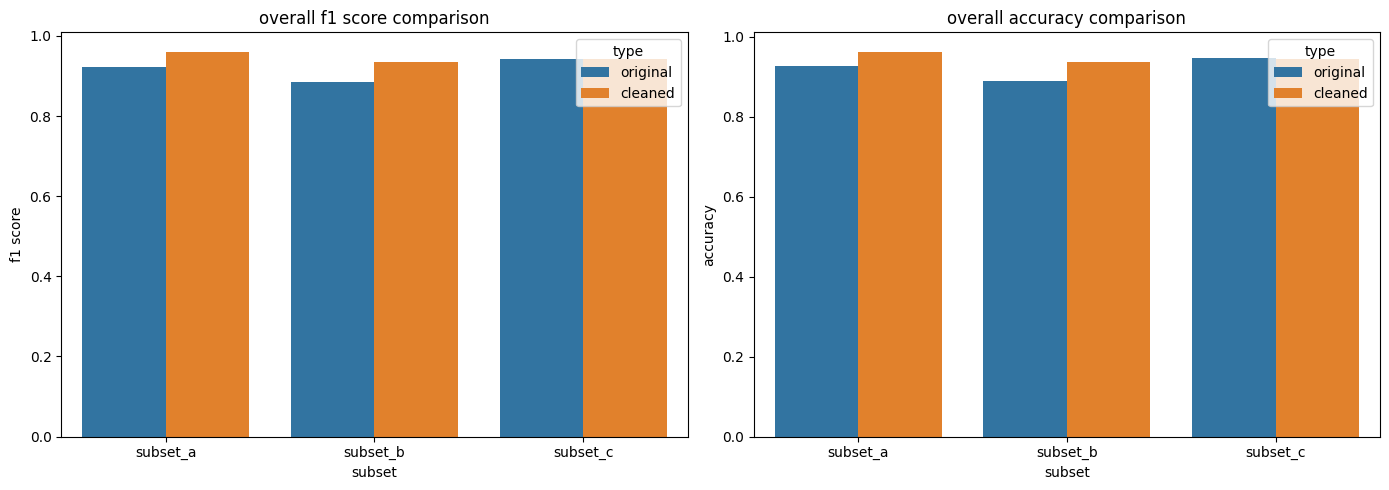

In [29]:
# extract f1 scores for overall comparison and per-fold scores for statistical testing
f1_overall_original = [results[name]['f1'] for name in results if 'original' in name]
f1_overall_cleaned = [results[name]['f1'] for name in results if 'cleaned' in name]

# prepare per-fold f1 scores for paired statistical comparison
# we need to ensure the order of original and cleaned datasets matches for pairing
subset_names = sorted(list(set([name.replace('_original', '').replace('_cleaned', '') for name in results])))

print(f"\n--- statistical comparison (paired wilcoxon test on per-fold f1 scores) ---")
statistical_conclusions = []

for subset in subset_names:
    original_f1_folds = results[f'{subset}_original']['f1_scores_per_fold']
    cleaned_f1_folds = results[f'{subset}_cleaned']['f1_scores_per_fold']

    if len(original_f1_folds) == len(cleaned_f1_folds) and len(original_f1_folds) > 1:
        stat, p = wilcoxon(original_f1_folds, cleaned_f1_folds, alternative='less') # alternative='less' tests if cleaned > original
        print(f"\n{subset}:")
        print(f"  wilcoxon signed-rank test p-value: {p:.4f}")
        if p < 0.05:
            conclusion = f"  conclusion: for {subset}, data cleaning shows a statistically significant improvement in f1 score."
            print(conclusion)
        else:
            conclusion = f"  conclusion: for {subset}, no statistically significant improvement in f1 score from data cleaning."
            print(conclusion)
        statistical_conclusions.append((subset, p, conclusion))
    else:
        print(f"\nnot enough per-fold data points for statistical comparison for {subset} (need at least 2 pairs).")


# visualization of overall F1 scores and accuracies
metrics_df = pd.DataFrame({
    'dataset': [name.replace('_original', '').replace('_cleaned', '') for name in results],
    'type': ['original' if 'original' in name else 'cleaned' for name in results],
    'f1_score': [res['f1'] for res in results.values()], # these are overall f1 scores
    'accuracy': [res['accuracy'] for res in results.values()] # these are overall accuracy scores
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x='dataset', y='f1_score', hue='type', data=metrics_df, ax=axes[0])
axes[0].set_title('overall f1 score comparison')
axes[0].set_ylabel('f1 score')
axes[0].set_xlabel('subset')

sns.barplot(x='dataset', y='accuracy', hue='type', data=metrics_df, ax=axes[1])
axes[1].set_title('overall accuracy comparison')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('subset')

plt.tight_layout()
plt.show()

### Step 7: confusion matrix visualization (for each dataset)

lastly, let's visualize the confusion matrix for each trained model. these plots give us a really clear picture of how many true positives, true negatives, false positives, and false negatives our model is generating for each class. it helps us directly see where the model is performing well and where it might be getting confused, which is super useful for fine-tuning our approach.

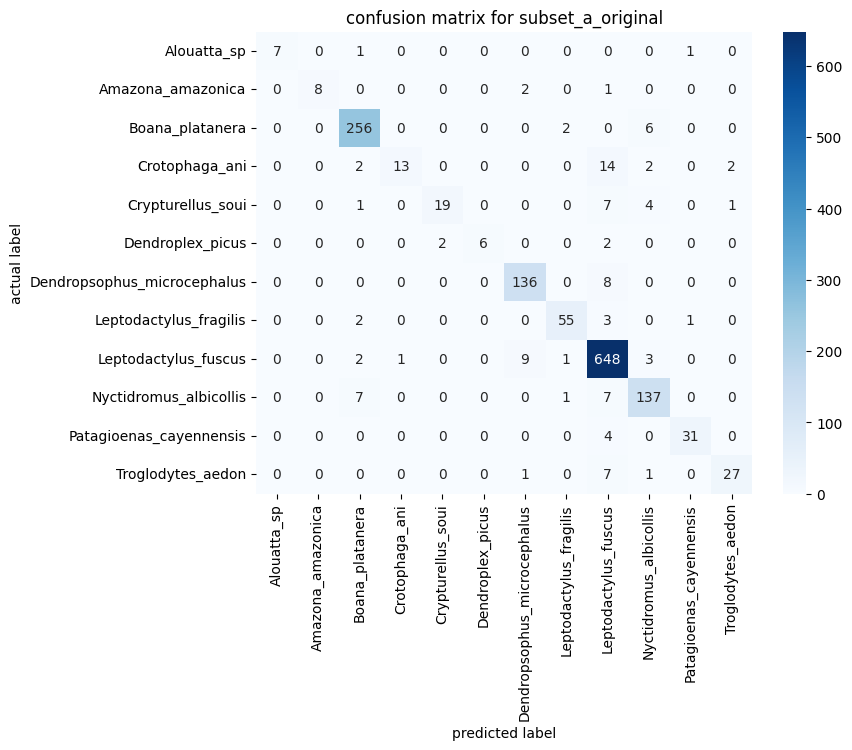

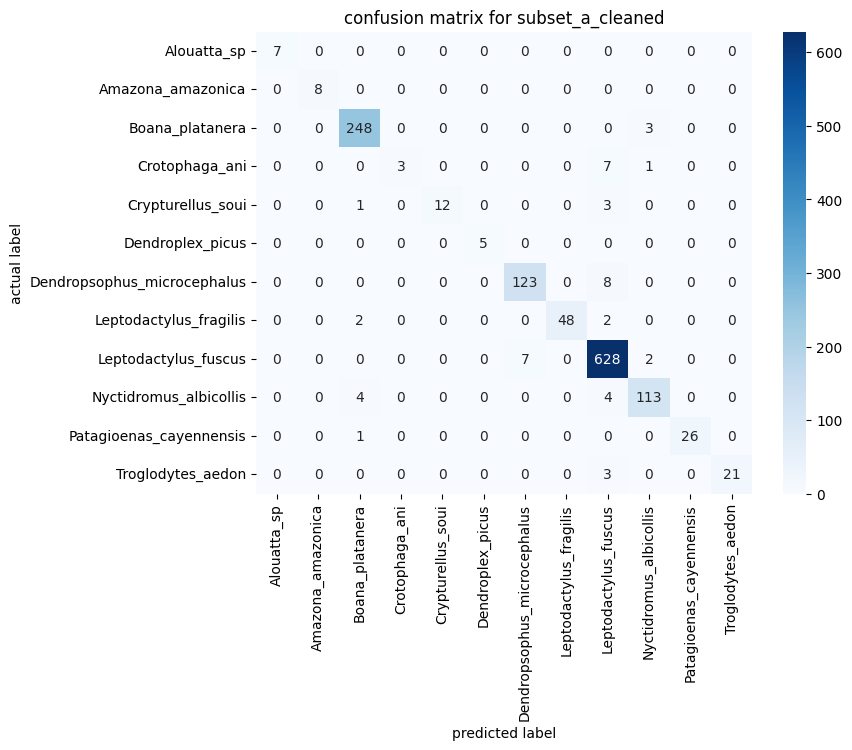

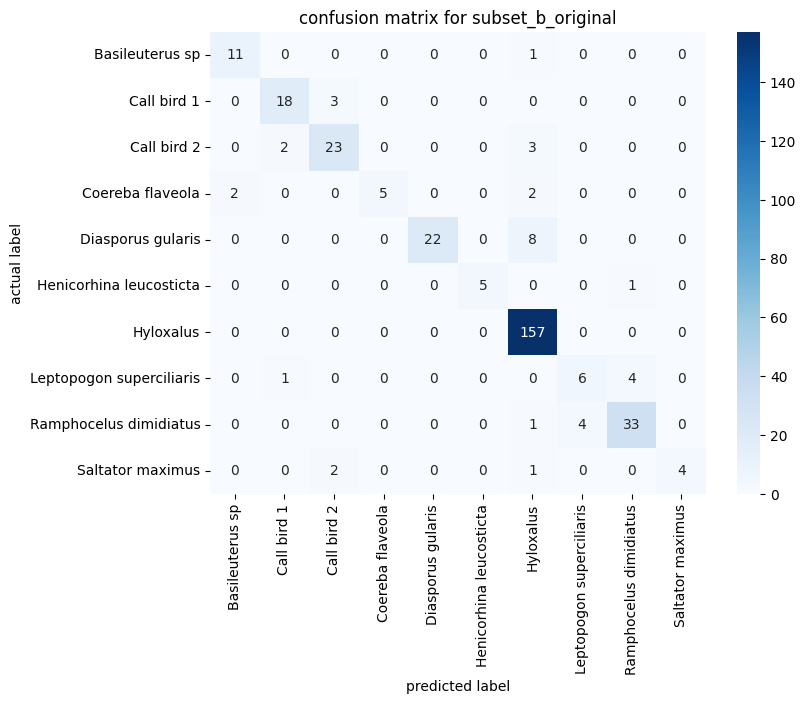

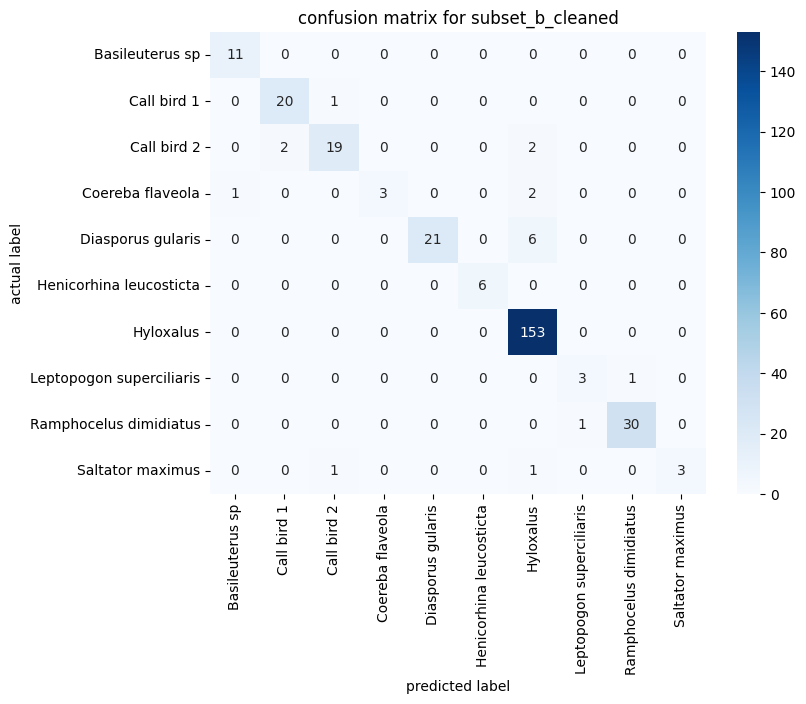

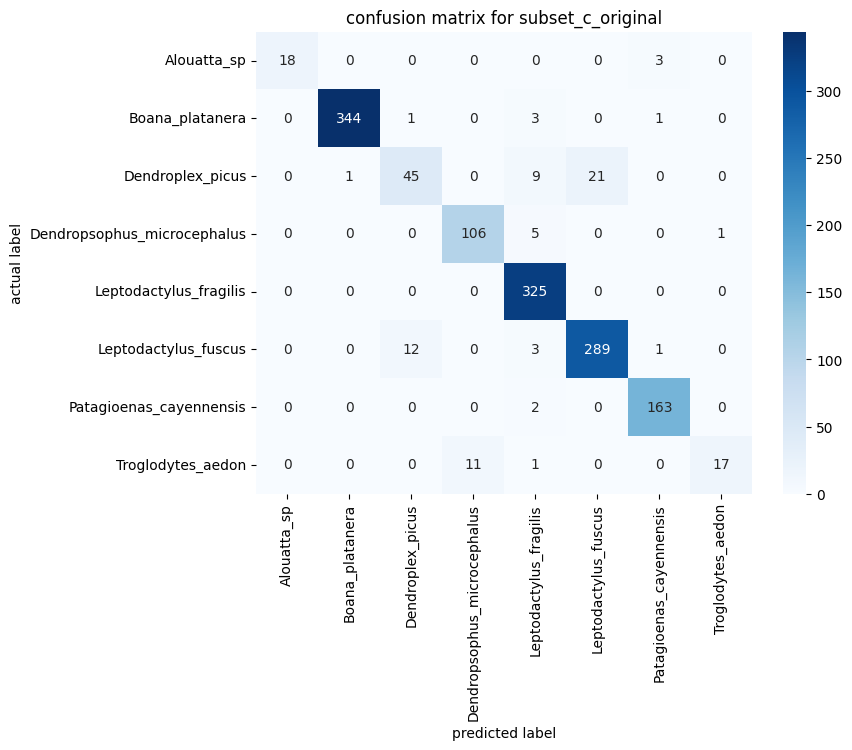

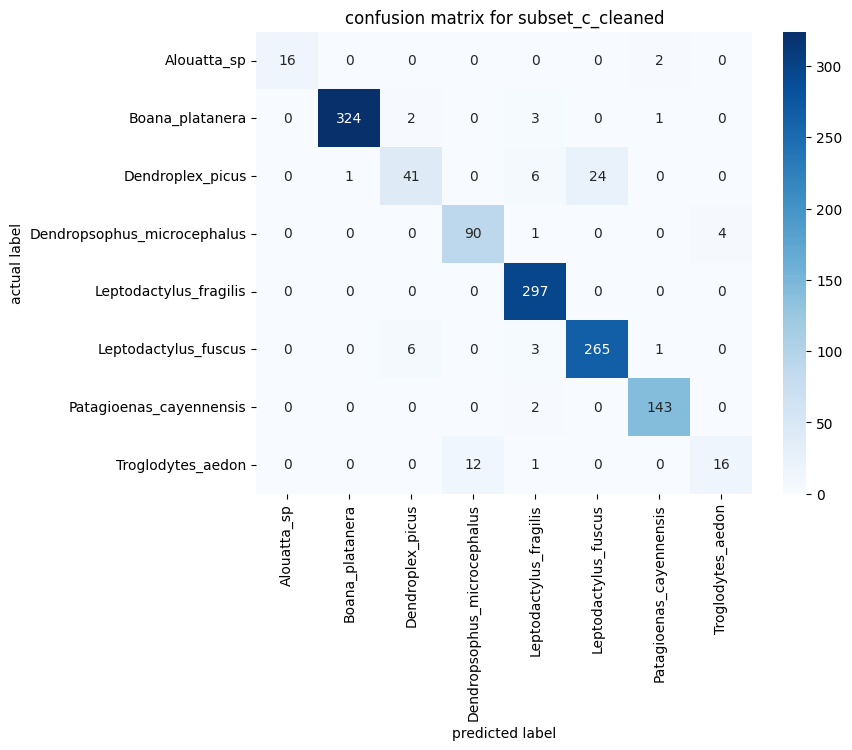

In [28]:
for name, res in results.items():
    plt.figure(figsize=(8, 6))
    label_encoder = res['label_encoder'] # retrieve the label encoder
    sns.heatmap(res['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, # use original class names
                yticklabels=label_encoder.classes_) # use original class names
    plt.title(f'confusion matrix for {name}')
    plt.ylabel('actual label')
    plt.xlabel('predicted label')
    plt.show()